In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
!unzip c.zip

Archive:  c.zip
   creating: New folder (10)/New folder (9)/
  inflating: New folder (10)/New folder (9)/0_2000.jpg  
  inflating: New folder (10)/New folder (9)/1_2000.jpg  
  inflating: New folder (10)/New folder (9)/10_2000.jpg  
  inflating: New folder (10)/New folder (9)/100_2000.jpg  
  inflating: New folder (10)/New folder (9)/10035_2004.jpg  
  inflating: New folder (10)/New folder (9)/101_2000.jpg  
  inflating: New folder (10)/New folder (9)/102_2000.jpg  
  inflating: New folder (10)/New folder (9)/103_2000.jpg  
  inflating: New folder (10)/New folder (9)/104_2000.jpg  
  inflating: New folder (10)/New folder (9)/105_2000.jpg  
  inflating: New folder (10)/New folder (9)/106_2000.jpg  
  inflating: New folder (10)/New folder (9)/107_2000.jpg  
  inflating: New folder (10)/New folder (9)/108_2000.jpg  
  inflating: New folder (10)/New folder (9)/109_2000.jpg  
  inflating: New folder (10)/New folder (9)/11_2000.jpg  
  inflating: New folder (10)/New folder (9)/110_2000.jpg  

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile


In [4]:

dataroot = "/content/New folder (10)"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([

                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [6]:
dataset = keras.utils.image_dataset_from_directory(
    dataroot, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 548 files belonging to 1 classes.


In [7]:
dataset = keras.utils.image_dataset_from_directory(
    dataroot, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 548 files belonging to 1 classes.


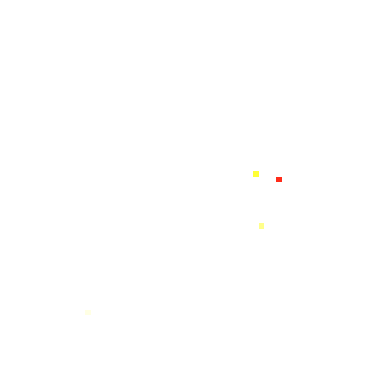

In [8]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [9]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [10]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [11]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("/content/output.png")

In [13]:
model= GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [21]:
epochs = 50

In [22]:
model.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [23]:
model.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
18/18 [==============================] - 8s 250ms/step - d_loss: 0.6771 - g_loss: 2.0413
Epoch 2/50
18/18 [==============================] - 5s 252ms/step - d_loss: 0.3082 - g_loss: 1.6143
Epoch 3/50
18/18 [==============================] - 5s 257ms/step - d_loss: 0.1785 - g_loss: 1.7365
Epoch 4/50
18/18 [==============================] - 5s 259ms/step - d_loss: 0.1246 - g_loss: 2.0136
Epoch 5/50
18/18 [==============================] - 5s 263ms/step - d_loss: 0.0906 - g_loss: 2.3695
Epoch 6/50
18/18 [==============================] - 5s 268ms/step - d_loss: 0.0682 - g_loss: 2.8171
Epoch 7/50
18/18 [==============================] - 5s 271ms/step - d_loss: 0.0478 - g_loss: 3.2601
Epoch 8/50
18/18 [==============================] - 5s 272ms/step - d_loss: 0.0369 - g_loss: 3.6312
Epoch 9/50
18/18 [==============================] - 5s 269ms/step - d_loss: 0.0304 - g_loss: 3.9170
Epoch 10/50
18/18 [==============================] - 5s 265ms/step - d_loss: 0.0145 - g_loss: 4.2415